In [16]:
import torch
import os
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from pathlib import Path

In [17]:
image_path = Path("Sugarcane Dataset")

Data Exploration

In [4]:
import os
def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir(image_path)

There are 5 directories and 0 images in 'Sugarcane Dataset'.
There are 0 directories and 522 images in 'Sugarcane Dataset\Healthy'.
There are 0 directories and 462 images in 'Sugarcane Dataset\Mosaic'.
There are 0 directories and 518 images in 'Sugarcane Dataset\RedRot'.
There are 0 directories and 514 images in 'Sugarcane Dataset\Rust'.
There are 0 directories and 505 images in 'Sugarcane Dataset\Yellow'.


Random Image Path: Sugarcane Dataset\Yellow\yellow (344).jpeg
Image Class: Yellow
Image Height: 1040
Image Width: 493


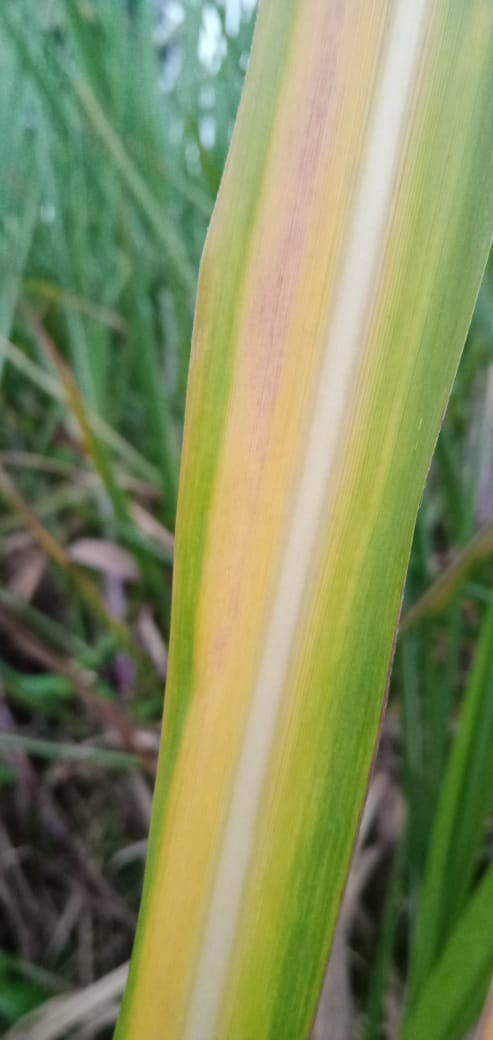

In [19]:
import random
from PIL import Image

image_path_list = list(image_path.glob("*/*.jpeg"))

random_image_path = random.choice(image_path_list)
image_class = random_image_path.parent.stem

img = Image.open(random_image_path)

print(f"Random Image Path: {random_image_path}")
print(f"Image Class: {image_class}")
print(f"Image Height: {img.height}")
print(f"Image Width: {img.width}")
img

(-0.5, 492.5, 1039.5, -0.5)

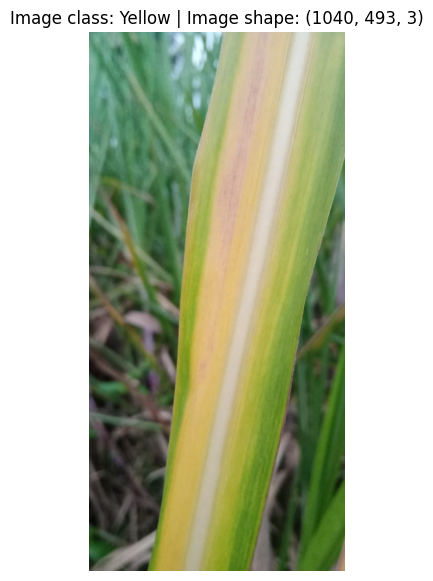

In [20]:
img_as_array = np.asarray(img)
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape}")
plt.axis(False)

Transforming Data


In [21]:
from torchvision.transforms import v2

transforms = v2.Compose([
    v2.Resize(size =(224,224), antialias=True),
    v2.RandomHorizontalFlip(0.5),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
])
transforms(img)

Image([[[0.6667, 0.6706, 0.6706,  ..., 0.3686, 0.3529, 0.3451],
        [0.6745, 0.6745, 0.6824,  ..., 0.3804, 0.3529, 0.3412],
        [0.6824, 0.6902, 0.6980,  ..., 0.3725, 0.3451, 0.3373],
        ...,
        [0.7176, 0.6941, 0.6627,  ..., 0.1176, 0.0980, 0.0980],
        [0.7255, 0.7098, 0.6824,  ..., 0.2196, 0.1569, 0.1412],
        [0.7294, 0.7098, 0.6863,  ..., 0.2941, 0.2392, 0.2078]],

       [[0.7333, 0.7373, 0.7333,  ..., 0.5765, 0.5686, 0.5647],
        [0.7373, 0.7373, 0.7451,  ..., 0.5882, 0.5725, 0.5686],
        [0.7412, 0.7451, 0.7490,  ..., 0.5922, 0.5725, 0.5725],
        ...,
        [0.5765, 0.5608, 0.5373,  ..., 0.1647, 0.1451, 0.1490],
        [0.5804, 0.5686, 0.5490,  ..., 0.2392, 0.1843, 0.1686],
        [0.5804, 0.5686, 0.5451,  ..., 0.3098, 0.2549, 0.2275]],

       [[0.5608, 0.5647, 0.5647,  ..., 0.4980, 0.4784, 0.4745],
        [0.5608, 0.5608, 0.5686,  ..., 0.5059, 0.4824, 0.4706],
        [0.5569, 0.5647, 0.5686,  ..., 0.4941, 0.4745, 0.4706],
        ..

In [22]:
transforms(img).shape

torch.Size([3, 224, 224])

In [23]:
dataset = datasets.ImageFolder(root=image_path, transform = transforms)
train_ratio = 0.8
test_ratio = 0.2
dataset.classes

['Healthy', 'Mosaic', 'RedRot', 'Rust', 'Yellow']

In [24]:
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import DataLoader, Subset
targets = [label for _, label in dataset.samples]

# Define the split ratio
train_ratio = 0.8
test_ratio = 0.2

# Create stratified split
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=test_ratio, train_size=train_ratio)

# Get train and test indices
train_indices, test_indices = next(strat_split.split(np.zeros(len(targets)), targets))

# Create train and test subsets
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Print the number of samples in each set
print(f'Number of training samples: {len(train_dataset)}')
print(f'Number of testing samples: {len(test_dataset)}')

# Verify the class distribution in each set
train_targets = [targets[i] for i in train_indices]
test_targets = [targets[i] for i in test_indices]

print(f'Training set class distribution: {np.bincount(train_targets)}')
print(f'Testing set class distribution: {np.bincount(test_targets)}')

Number of training samples: 2016
Number of testing samples: 505
Training set class distribution: [417 370 414 411 404]
Testing set class distribution: [105  92 104 103 101]


In [25]:
class_dict = dataset.class_to_idx
class_dict

{'Healthy': 0, 'Mosaic': 1, 'RedRot': 2, 'Rust': 3, 'Yellow': 4}

In [26]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [31]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16,5)
        self.fc1 = nn.Linear(16*53*53,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
        self.dropout = nn.Dropout(0.5)

    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x,1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()

In [32]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [35]:
import torch.optim as optim

# Define your network, criterion, optimizer, and data loader (trainloader) here

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

for epoch in range(30):  # loop over the dataset multiple times

    running_loss = 0.0
    correct = 0
    total = 0

    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # accumulate loss
        running_loss += loss.item()

        # calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # print statistics every 2000 mini-batches
        if i % 2000 == 1999:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

    # print loss and accuracy for each epoch
    accuracy = 100 * correct / total
    print(f'Epoch {epoch + 1} - Loss: {running_loss / len(train_loader):.3f}, Accuracy: {accuracy:.2f}%')

print('Finished Training')


Epoch 1 - Loss: 0.292, Accuracy: 89.29%
Epoch 2 - Loss: 0.225, Accuracy: 91.42%
Epoch 3 - Loss: 0.255, Accuracy: 90.97%
Epoch 4 - Loss: 0.249, Accuracy: 90.58%
Epoch 5 - Loss: 0.192, Accuracy: 92.76%
Epoch 6 - Loss: 0.207, Accuracy: 92.26%
Epoch 7 - Loss: 0.195, Accuracy: 92.21%
Epoch 8 - Loss: 0.199, Accuracy: 92.51%
Epoch 9 - Loss: 0.176, Accuracy: 93.90%
Epoch 10 - Loss: 0.178, Accuracy: 93.65%
Epoch 11 - Loss: 0.159, Accuracy: 93.85%
Epoch 12 - Loss: 0.157, Accuracy: 93.85%
Epoch 13 - Loss: 0.137, Accuracy: 95.04%
Epoch 14 - Loss: 0.159, Accuracy: 93.70%
Epoch 15 - Loss: 0.164, Accuracy: 93.90%
Epoch 16 - Loss: 0.170, Accuracy: 93.85%
Epoch 17 - Loss: 0.163, Accuracy: 93.90%
Epoch 18 - Loss: 0.150, Accuracy: 94.79%
Epoch 19 - Loss: 0.161, Accuracy: 93.75%
Epoch 20 - Loss: 0.157, Accuracy: 94.00%
Epoch 21 - Loss: 0.146, Accuracy: 94.25%
Epoch 22 - Loss: 0.108, Accuracy: 96.03%
Epoch 23 - Loss: 0.121, Accuracy: 95.19%
Epoch 24 - Loss: 0.159, Accuracy: 93.85%
Epoch 25 - Loss: 0.107, A